In [ ]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import torch
import torch.nn as nn
from timm import create_model
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

import random
import numpy as np

def seed_everything(seed=28):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(28)

# ✅ 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_root = f'../data/train2_augmented'
test_csv_path = '../data/test.csv'
sample_sub_path = '../data/sample_submission.csv'
save_dir = '../submissions'
base_save_dir = '../checkpoints'
num_epochs = 50
batch_size = 32

best_model_name = 'swin_tiny_patch4_window7_224'
# best_model_name = 'vit_base_patch16_224'

# ✅ 전체 데이터로 재학습
from dataloaders.loaders import get_dataloaders
from models.train_utils import train_one_epoch
from timm.loss import SoftTargetCrossEntropy
import torch.nn.functional as F

def rand_bbox(size, lam):
    W = size[3]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_cutmix(x, y, num_classes, beta=1.0, cutmix_prob=0.5):
    if np.random.rand() > cutmix_prob:
        return x, F.one_hot(y, num_classes=num_classes).float()

    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    y1 = F.one_hot(y, num_classes=num_classes).float()
    y2 = y1[rand_index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bby1:bby2, bbx1:bbx2] = x[rand_index, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    y_mix = y1 * lam + y2 * (1. - lam)
    return x, y_mix

def apply_mixup(x, y, num_classes, alpha=1.0, mixup_prob=0.5):
    if np.random.rand() > mixup_prob:
        return x, F.one_hot(y, num_classes=num_classes).float()

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    
    x1, x2 = x, x[rand_index]
    y1 = F.one_hot(y, num_classes=num_classes).float()
    y2 = y1[rand_index]

    x_mix = lam * x1 + (1 - lam) * x2
    y_mix = lam * y1 + (1 - lam) * y2
    return x_mix, y_mix

def hybrid_augmentation(x, y, num_classes, alpha=1.0, beta=1.0, prob_mixup=0.5):
    if np.random.rand() < prob_mixup:
        return apply_mixup(x, y, num_classes, alpha=alpha, mixup_prob=1.0)
    else:
        return apply_cutmix(x, y, num_classes, beta=beta, cutmix_prob=1.0)
    

dataloaders = get_dataloaders(data_root, batch_size=batch_size, val_ratio=0.0, return_path=False)
train_loader = dataloaders[best_model_name]['train']
class_names = dataloaders[best_model_name]['classes']
num_classes = len(class_names)

model = create_model(best_model_name, pretrained=True, num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# cutmix_fn 정의
cutmix_fn = lambda x, y: apply_cutmix(x, y, num_classes=num_classes, beta=1.0, cutmix_prob=0.5)
# mixup_fn 정의
mixup_fn = lambda x, y: apply_mixup(x, y, num_classes=num_classes, alpha=1.0, mixup_prob=0.5)
# hybrid cutmix/mixup 정의
hybrid_fn = lambda x, y: hybrid_augmentation(
    x, y, num_classes=num_classes, alpha=1.0, beta=1.0, prob_mixup=0.5
)


# criterion 변경
criterion = SoftTargetCrossEntropy()  # Mixup & CutMix 사용 시
# criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

os.makedirs(base_save_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("🔁 전체 학습 데이터로 재학습 시작")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, hybrid_fn)
    print(f"📘 Epoch {epoch + 1} 🔹 Training Loss: {train_loss:.4f} 🔹 Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    scheduler.step()

    # ✅ 선택된 에포크에만 모델 저장
    if (epoch + 1) in [30, 35, 40, 45, 50]:
        save_name = f"{best_model_name}_epoch{epoch+1}_{timestamp}.pth"
        save_path = os.path.join(base_save_dir, save_name)
        torch.save(model.state_dict(), save_path)
        print(f"💾 모델 저장 완료 (Epoch {epoch+1}): {save_path}")

model.eval()

# ✅ 테스트 전처리
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ✅ 테스트 데이터 로드
test_df = pd.read_csv(test_csv_path)
submission_template = pd.read_csv(sample_sub_path)
submission_class_names = submission_template.columns.tolist()[1:]

# ✅ 예측
results = []
with torch.no_grad():
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc='🔍 테스트셋 예측'):
        img_path = os.path.join('../data', row['img_path'])
        image = Image.open(img_path).convert('RGB')

        input_tensor = transform(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1).squeeze().cpu().numpy()
        results.append(prob)

# ✅ 제출 파일 생성
submission_df = pd.DataFrame(results, columns=class_names)
submission_df.insert(0, 'ID', test_df['ID'])

os.makedirs(save_dir, exist_ok=True)
submission_path = os.path.join(save_dir, f'submission_{best_model_name}_{timestamp}.csv')
submission_df.to_csv(submission_path, index=False)

print(f"✅ 제출 파일 저장 완료: {submission_path}\n")


🔁 전체 학습 데이터로 재학습 시작


📘 Epoch 1 🔹 Training Loss: 4.7880 🔹 Learning Rate: 0.000100


📘 Epoch 2 🔹 Training Loss: 3.0896 🔹 Learning Rate: 0.000100


Train:  16%|█▌        | 189/1173 [01:26<07:29,  2.19it/s]

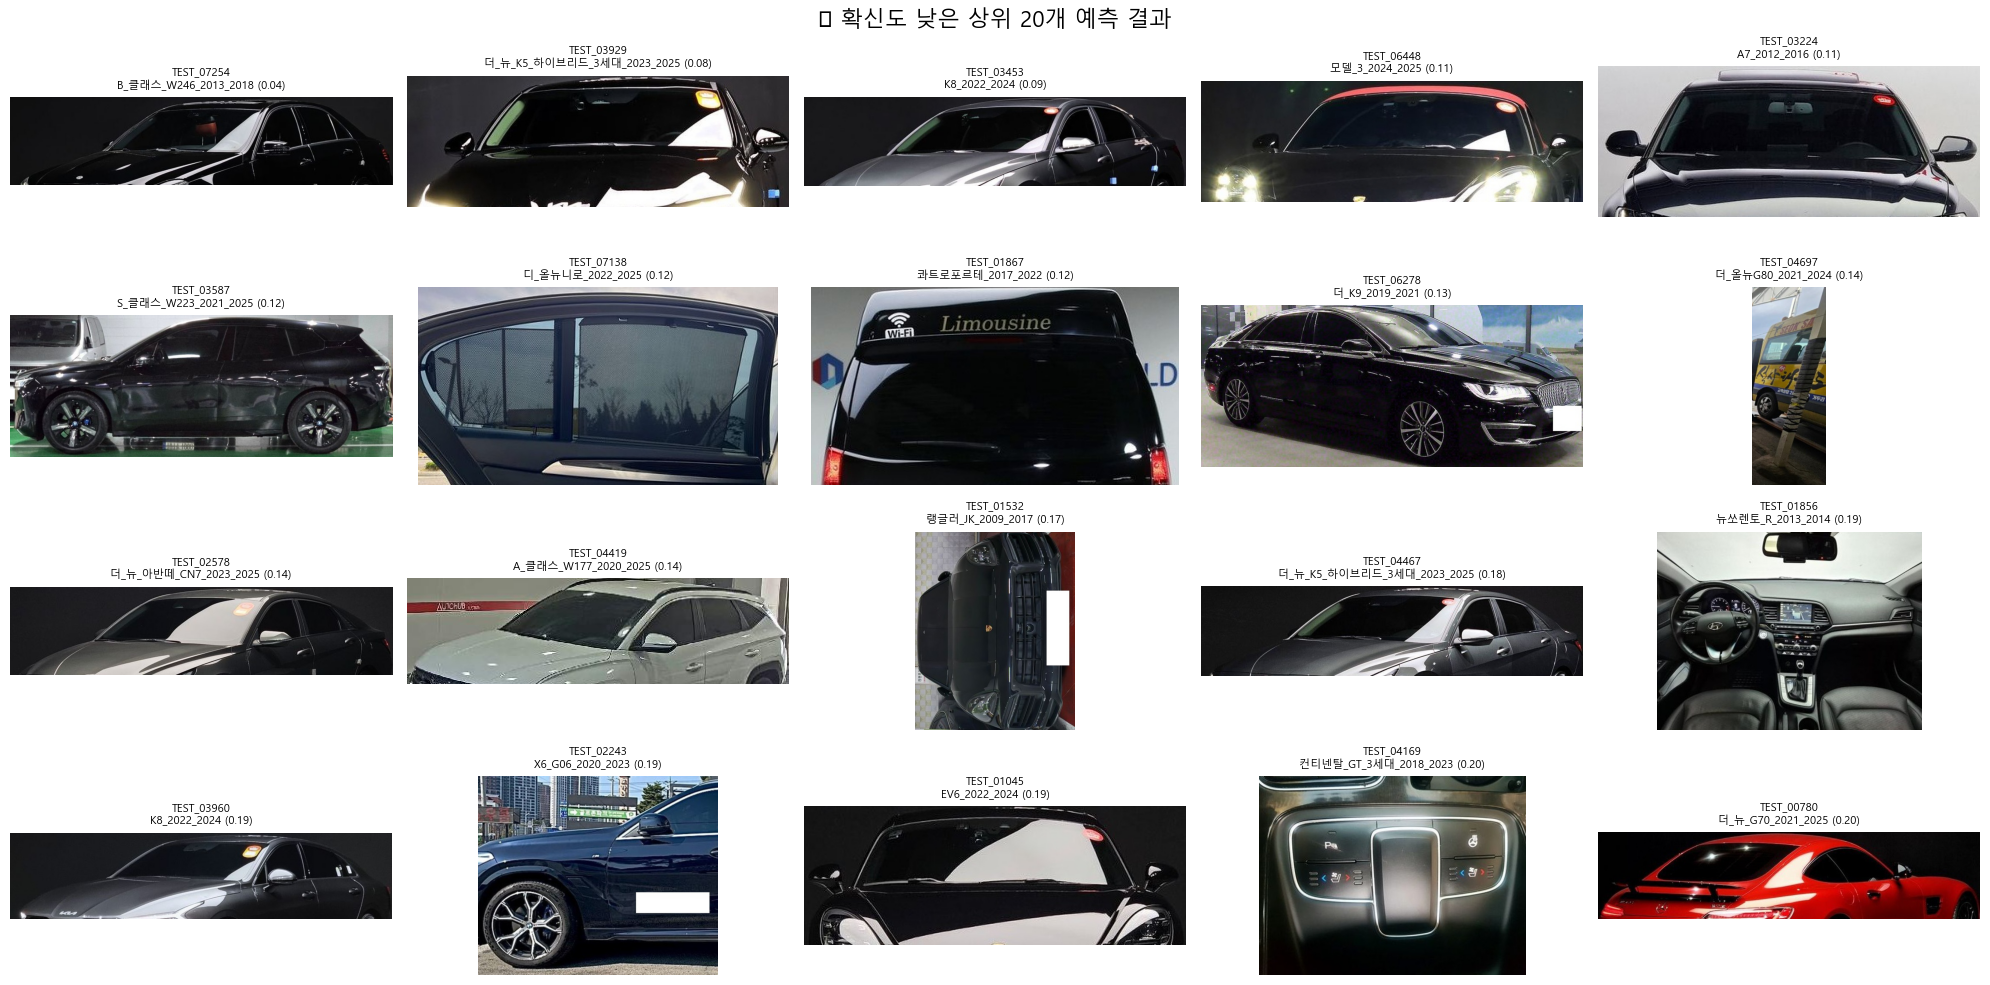

In [2]:
import matplotlib.pyplot as plt
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# ✅ 확신도 계산
probs = np.array(results)  # shape: (num_samples, num_classes)
confidences = probs.max(axis=1)  # 각 샘플의 최고 확률값

# 확신도 낮은 20개 인덱스
low_conf_indices = np.argsort(confidences)[:20]

# 시각화
plt.figure(figsize=(20, 10))
for i, idx in enumerate(low_conf_indices):
    img_path = os.path.join('../data', test_df.loc[idx, 'img_path'])
    image = Image.open(img_path).convert('RGB')

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    
    pred_label = class_names[np.argmax(probs[idx])]
    plt.title(f"{test_df.loc[idx, 'ID']}\n{pred_label} ({confidences[idx]:.2f})", fontsize=8)

plt.suptitle("🔍 확신도 낮은 상위 20개 예측 결과", fontsize=16)
plt.tight_layout()
plt.show()


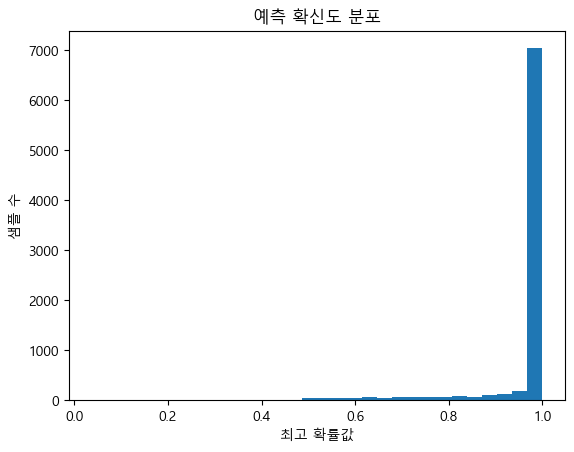

In [4]:
plt.hist(confidences, bins=30)
plt.title("예측 확신도 분포")
plt.xlabel("최고 확률값")
plt.ylabel("샘플 수")
plt.show()


In [3]:
import numpy as np
import pandas as pd

# 확신도 및 예측 결과
y_pred = np.argmax(probs, axis=1)
confidences = np.max(probs, axis=1)
num_classes = probs.shape[1]

# 클래스별 확신도 평균 저장
class_conf_avg = {}

for class_idx in range(num_classes):
    indices = np.where(y_pred == class_idx)[0]  # 해당 클래스로 예측된 샘플
    if len(indices) == 0:
        class_conf_avg[class_idx] = np.nan  # 예측된 샘플이 없으면 NaN 처리
    else:
        class_conf_avg[class_idx] = np.mean(confidences[indices])

# DataFrame으로 정리 후 정렬
conf_df = pd.DataFrame({
    'class_idx': list(class_conf_avg.keys()),
    'avg_confidence': list(class_conf_avg.values()),
    'class_name': [class_names[i] for i in class_conf_avg.keys()]
}).dropna()

conf_df_sorted = conf_df.sort_values(by='avg_confidence').head(20)
conf_df_sorted

,class_idx,avg_confidence,class_name
15,15,0.647362,4시리즈_G22_2024_2025
381,381,0.655314,트레일블레이저_2023
99,99,0.668832,K8_2022_2024
336,336,0.672907,올_뉴_K7_하이브리드_2017_2019
97,97,0.703000,K7_프리미어_2020_2021
98,98,0.714482,K7_프리미어_하이브리드_2020_2021
335,335,0.725796,올_뉴_K7_2016_2019
277,277,0.757880,레인지로버_이보크_2세대_2023_2024
210,210,0.758015,더_뉴_K5_3세대_2024_2025
100,100,0.766347,K8_하이브리드_2022_2024


In [8]:
import pandas as pd

# 3개의 submission 불러오기
sub1 = pd.read_csv('../submissions/submission_swin_tiny_patch4_window7_224_20250528_023613.csv')
sub2 = pd.read_csv('../submissions/submission_swin_tiny_patch4_window7_224_20250529_033023.csv')
sub3 = pd.read_csv('../submissions/submission_vit_base_patch16_224_20250529_174517.csv')

# ID 컬럼 제외하고 평균
ensemble = sub1.copy()
ensemble.iloc[:, 1:] = (sub1.iloc[:, 1:] + sub2.iloc[:, 1:] + sub3.iloc[:, 1:]) / 3

# argmax로 최종 클래스 예측 확인 (필요시)
final_preds = ensemble.iloc[:, 1:].values.argmax(axis=1)
ensemble['Pred'] = final_preds
ensemble.to_csv('../submissions/ensemble_submission.csv', index=False)
